# Natural Lnaguege Processsing - Knowledge Graph example

In [74]:
import warnings
warnings.filterwarnings('ignore')

## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for text
import wikipediaapi
import nltk
import re

## for nlp
import spacy
from spacy import displacy
import textacy

## for graph
import networkx as nx
import plotly.graph_objs as go

## for timeline
import dateparser

Importamos la data

In [111]:
nlp = spacy.load('en_core_web_sm')  # Carga el modelo
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")  # Procesa el texto

for ent in doc.ents:
    print(ent.text, ent.label_)  # Reconocimiento de entidades

Apple ORG
U.K. GPE
$1 billion MONEY


In [75]:
topic = "Russo-Ukrainian War"

# Especifica un user agent adecuado aquí
user_agent = "MyUserAgent/1.0 (egoitzaulestia@gmail.com)"

wiki = wikipediaapi.Wikipedia(user_agent=user_agent)
page = wiki.page(topic)
txt = page.text[:page.text.find("See also")]

print(txt[0:500] + " ...")

The Russo-Ukrainian War is an ongoing international conflict between Russia and Ukraine, which began in February 2014. Following Ukraine's Revolution of Dignity, Russia annexed Crimea from Ukraine and supported pro-Russian separatists fighting the Ukrainian military in the Donbas war. The first eight years of conflict also included naval incidents, cyberwarfare, and heightened political tensions. In February 2022, Russia launched a full-scale invasion of Ukraine and began occupying more of the c ...


In [76]:
'''
Compute n-grams frequency with nltk tokenizer.
:parameter
    :param txt: text
    :param ngrams: int or list - 1 for unigrams, 2 for bigrams, [1,2] for both
    :param top: num - plot the top frequent words
:return
    dtf_count: dtf with word frequency
'''
def word_freq(txt, ngrams=[1,2,3], top=10, figsize=(10,7)):
    lst_tokens = nltk.tokenize.word_tokenize(txt)
    ngrams = [ngrams] if type(ngrams) is int else ngrams
    
    ## calculate
    dtf_freq = pd.DataFrame()
    for n in ngrams:
        dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, n))
        dtf_n = pd.DataFrame(dic_words_freq.most_common(), columns=["word","freq"])
        dtf_n["ngrams"] = n
        dtf_freq = pd.concat([dtf_freq, dtf_n])
    dtf_freq["word"] = dtf_freq["word"].apply(lambda x: " ".join(string for string in x) )
    dtf_freq = dtf_freq.sort_values(["ngrams","freq"], ascending=[True,False])
    
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    sns.barplot(x="freq", y="word", hue="ngrams", dodge=False, ax=ax,
                data=dtf_freq.groupby('ngrams')[["ngrams","freq","word"]].head(top))
    ax.set(xlabel=None, ylabel=None, title="Most frequent words")
    ax.grid(axis="x")
    plt.show()
    return dtf_freq

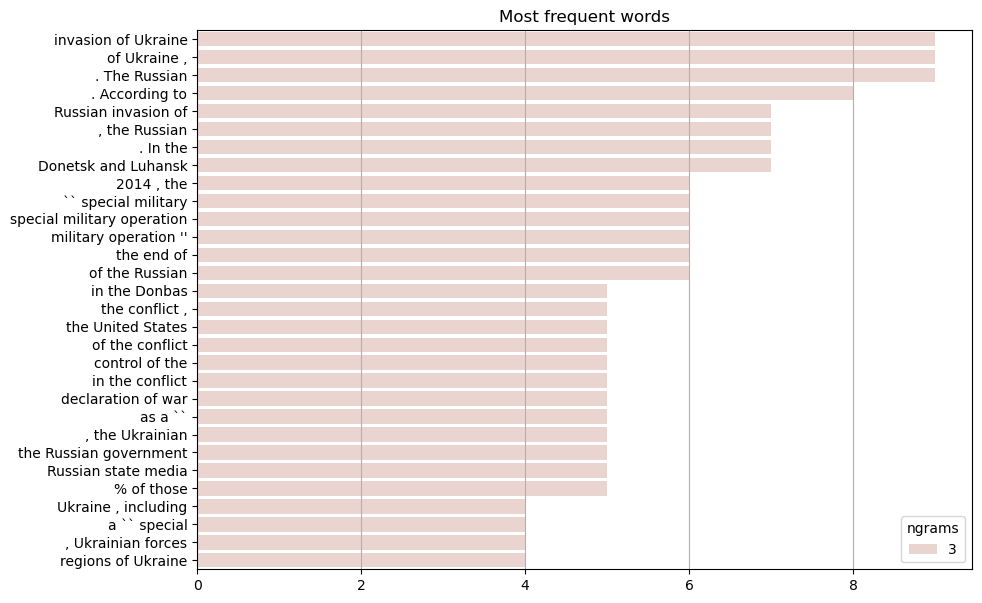

In [77]:
_ = word_freq(txt, ngrams=[3], top=30, figsize=(10,7))

# **1 - NLP**

### Antes de crear un Grafo de Conocimiento, Lo primero que debemos hacer es encontrar entidades y relaciones.

Hoy en día, la librería más usada para eso es Spacy, una librería open-source para NLP avanzado que se aprovecha de Cython (C+Python). Spacy usa modelos de lenguaje preentrenados para tokenizar el texto y transformaarlo en un objeto comunmente llamado "document", basicamente, una clase que contiene todas las anotaciones predichas por el modelo.

### **Model**

In [78]:
# python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")
doc = nlp(txt)

### **Sentence Segmentation**

In [79]:
lst_docs = [sent for sent in doc.sents]
print("tot sentences:", len(lst_docs))

i = 3
lst_docs[i]

tot sentences: 392


In February 2022, Russia launched a full-scale invasion of Ukraine and began occupying more of the country.

### **POS/DEP**

##### **POS** (Part-of-Speech)

De cada oración, vamos a extraer entidades y sus relaciones. Para hacer eso, primero necesitamos entender el  `Part-of-Speech (POS) tagging` (etiquetado de Partes del Discurso), que es el proceso de etiquetar cada palabra en una oración con su etiqueta gramatical apropiada. 

Aquí está la lista completa de etiquetas posibles (hasta el día de hoy):

- **ADJ:** adjetivo, por ejemplo, grande, viejo, verde, incomprensible, primero (ADJ: adjective, e.g. big, old, green, incomprehensible, first)
- **ADP:** adposición (preposición/posposición), por ejemplo, en, hacia, durante (ADP: adposition (preposition/postposition) e.g. in, to, during)
- **ADV:** adverbio, por ejemplo, muy, mañana, abajo, donde, allí (ADV: adverb, e.g. very, tomorrow, down, where, there)
- **AUX:** auxiliar, por ejemplo, es, ha (hecho), hará (hacer), debería (hacer) (AUX: auxiliary, e.g. is, has (done), will (do), should (do))
- **CONJ:** conjunción, por ejemplo, y, o, pero (CONJ: conjunction, e.g. and, or, but)
- **CCONJ:** conjunción coordinante, por ejemplo, y, o, pero (CCONJ: coordinating conjunction, e.g. and, or, but)
- **DET:** determinante, por ejemplo, un, una, el, la (DET: determiner, e.g. a, an, the)
- **INTJ:** interjección, por ejemplo, psst, ay, bravo, hola (INTJ: interjection, e.g. psst, ouch, bravo, hello)
- **NOUN:** sustantivo, por ejemplo, niña, gato, árbol, aire, belleza (NOUN: noun, e.g. girl, cat, tree, air, beauty)
- **NUM:** numeral, por ejemplo, 1, 2017, uno, setenta y siete, IV, MMXIV (NUM: numeral, e.g. 1, 2017, one, seventy-seven, IV, MMXIV)
- **PART:** partícula, por ejemplo, ‘s, no (PART: particle, e.g. ‘s, not)
- **PRON:** pronombre, por ejemplo, yo, tú, él, ella, mí mismo, ellos mismos, alguien (PRON: pronoun, e.g I, you, he, she, myself, themselves, somebody)
- **PROPN:** nombre propio, por ejemplo, María, Juan, Londres, OTAN, HBO (PROPN: proper noun, e.g. Mary, John, London, NATO, HBO)
- **PUNCT:** puntuación, por ejemplo, ., (, ), ? (PUNCT: punctuation, e.g. ., (, ), ?)
- **SCONJ:** conjunción subordinante, por ejemplo, si, mientras, que (SCONJ: subordinating conjunction, e.g. if, while, that)
- **SYM:** símbolo, por ejemplo, $, %, §, ©, +, −, ×, ÷, =, :), emojis (SYM: symbol, e.g. $, %, §, ©, +, −, ×, ÷, =, :), emojis)
- **VERB:** verbo, por ejemplo, correr, corre, corriendo, comer, comió, comiendo (VERB: verb, e.g. run, runs, running, eat, ate, eating)
- **X:** otro, por ejemplo, sfpksdpsxmsa (X: other, e.g. sfpksdpsxmsa)
- **SPACE:** espacio, por ejemplo, (SPACE: space, e.g. )







##### **DEP** (Dependency parsing)

El etiquetado POS por sí solo no es suficiente, el modelo también intenta comprender la realción entre pares de palabras. Esta tarea se llama `Dependency (DEP) parsing`, análisis de dependecias.

Aquí está la lista completa de etiquetas posibles (hasta el día de hoy):

- **ACL:** modificador clausal de sustantivo (ACL: clausal modifier of noun)
- **ACOMP:** complemento adjetival (ACOMP: adjectival complement)
- **ADVCL:** modificador de cláusula adverbial (ADVCL: adverbial clause modifier)
- **ADVMOD:** modificador adverbial (ADVMOD: adverbial modifier)
- **AGENT:** agente (AGENT: agent)
- **AMOD:** modificador adjetival (AMOD: adjectival modifier)
- **APPOS:** modificador de aposición (APPOS: appositional modifier)
- **ATTR:** atributo (ATTR: attribute)
- **AUX:** auxiliar (AUX: auxiliary)
- **AUXPASS:** auxiliar (pasivo) (AUXPASS: auxiliary (passive))
- **CASE:** marcador de caso (CASE: case marker)
- **CC:** conjunción coordinante (CC: coordinating conjunction)
- **CCOMP:** complemento clausal (CCOMP: clausal complement)
- **COMPOUND:** modificador compuesto (COMPOUND: compound modifier)
- **CONJ:** conjunción (CONJ: conjunct)
- **CSUBJ:** sujeto clausal (CSUBJ: clausal subject)
- **CSUBJPASS:** sujeto clausal (pasivo) (CSUBJPASS: clausal subject (passive))
- **DATIVE:** dativo (DATIVE: dative)
- **DEP:** dependiente no clasificado (DEP: unclassified dependent)
- **DET:** determinante (DET: determiner)
- **DOBJ:** objeto directo (DOBJ: direct object)
- **EXPL:** expletivo (EXPL: expletive)
- **INTJ:** interjección (INTJ: interjection)
- **MARK:** marcador (MARK: marker)
- **META:** modificador meta (META: meta modifier)
- **NEG:** modificador de negación (NEG: negation modifier)
- **NOUNMOD:** modificador de nominal (NOUNMOD: modifier of nominal)
- **NPMOD:** modificador de frase nominal como adverbial (NPMOD: noun phrase as adverbial modifier)
- **NSUBJ:** sujeto nominal (NSUBJ: nominal subject)
- **NSUBJPASS:** sujeto nominal (pasivo) (NSUBJPASS: nominal subject (passive))
- **NUMMOD:** modificador numérico (NUMMOD: number modifier)
- **OPRD:** predicado de objeto (OPRD: object predicate)
- **PARATAXIS:** parataxis (PARATAXIS: parataxis)
- **PCOMP:** complemento de preposición (PCOMP: complement of preposition)
- **POBJ:** objeto de preposición (POBJ: object of preposition)
- **POSS:** modificador de posesión (POSS: possession modifier)
- **PRECONJ:** conjunción pre-correlativa (PRECONJ: pre-correlative conjunction)
- **PREDET:** pre-determinante (PREDET: pre-determiner)
- **PREP:** modificador preposicional (PREP: prepositional modifier)
- **PRT:** partícula (PRT: particle)
- **PUNCT:** puntuación (PUNCT: punctuation)
- **QUANTMOD:** modificador de cuantificador (QUANTMOD: modifier of quantifier)
- **RELCL:** modificador de cláusula relativa (RELCL: relative clause modifier)
- **ROOT:** raíz (ROOT: root)
- **XCOMP:** complemento clausal abierto (XCOMP: open clausal complement)







In [80]:
# Escogemos una frase
i = 3
lst_docs[i]

In February 2022, Russia launched a full-scale invasion of Ukraine and began occupying more of the country.

In [81]:
for token in lst_docs[i]:
    print(token.text, "-->", "pos: " + token.pos_, "|", "dep: " + token.dep_,"")

In --> pos: ADP | dep: prep 
February --> pos: PROPN | dep: pobj 
2022 --> pos: NUM | dep: nummod 
, --> pos: PUNCT | dep: punct 
Russia --> pos: PROPN | dep: nsubj 
launched --> pos: VERB | dep: ROOT 
a --> pos: DET | dep: det 
full --> pos: ADJ | dep: amod 
- --> pos: PUNCT | dep: punct 
scale --> pos: NOUN | dep: compound 
invasion --> pos: NOUN | dep: dobj 
of --> pos: ADP | dep: prep 
Ukraine --> pos: PROPN | dep: pobj 
and --> pos: CCONJ | dep: cc 
began --> pos: VERB | dep: conj 
occupying --> pos: VERB | dep: xcomp 
more --> pos: ADJ | dep: dobj 
of --> pos: ADP | dep: prep 
the --> pos: DET | dep: det 
country --> pos: NOUN | dep: pobj 
. --> pos: PUNCT | dep: punct 

 --> pos: SPACE | dep: dep 


SpaCy provee una herrramienta de visualización

In [82]:
from spacy import displacy

displacy.render(lst_docs[i], style="dep", options={"distance": 100})

In [ ]:
from spacy import displacy
import cairosvg
import os
import re

# Suponiendo que lst_docs[i] es tu documento procesado por SpaCy
# Genera el gráfico de dependencias como SVG
svg = displacy.render(lst_docs[i], style="dep", options={"distance": 100}, jupyter=False)

# Verifica si ya existe un atributo de estilo en la etiqueta <svg>
if 'style="' in svg:
    # Añade el fondo blanco al estilo existente
    svg_with_background = re.sub(r'style="', 'style="background: white; ', svg, count=1)
else:
    # Añade un atributo de estilo con fondo blanco
    svg_with_background = svg.replace('<svg', '<svg style="background: white;"', 1)

# Guarda el SVG temporalmente con fondo blanco
with open("temp.svg", "w", encoding="utf-8") as file:
    file.write(svg_with_background)

# Convierte el SVG a PNG
cairosvg.svg2png(url='temp.svg', write_to='dependency_graph2.png')

# Elimina el archivo SVG temporal
os.remove("temp.svg")

1. El token más importante es el vervo (POS=VERB) porque es la raíz (DEP=ROOT) 

2. Las partículas auxiliares, como los adverbios y adposiciones (POS=ADV/ADP), a menudo se enlazan al verbo como modificadores (DEP=*mod), ya que pueden modificar el significado del verbo. Por ejemplo, "viajar a" y "viajar desde" tienen diferentes significados, aunque la raíz sea la misma ("viajar").

3. Entre las palbras vinculadas al verbo, debe haber algunos sustantivos (POS=PROPN/NOUN) que funcionen como sujeto y objeto (DEP=nsubj/*obj) de la oración.

4. Los sustantivos (nombres) a menudo están cerca de un adjetivo (POS=ADJ) que actúa como un modificador de su significado (DEP=amod). Por ejemplo, en "buena persona" y "mala persona", los adjetivos otorgan significados opuestos al sustantivo "persona".

---

### Name Entity Recognition (NER)

Otra tarea interesante realizada por SpaCy es el Named Entity Recognition (NER), Reconocimiento de Entidades Nombradas. Una entidad es un "real-world object" u "objeto del mundo real" (es decir, persona, país, producto, fecha) y los modelos pueden reconocer varios tipos en un documento. Aquí está la lista completa de etiquetas posibles (hasta el día de hoy):

- **PERSON:** personas, incluyendo ficticias (PERSON: people, including fictional).
- **NORP:** nacionalidades o grupos religiosos o políticos (NORP: nationalities or religious or political groups).
- **FAC:** edificios, aeropuertos, autopistas, puentes, etc. (FAC: buildings, airports, highways, bridges, etc.).
- **ORG:** compañías, agencias, instituciones, etc. (ORG: companies, agencies, institutions, etc.).
- **GPE:** países, ciudades, estados (GPE: countries, cities, states).
- **LOC:** ubicaciones que no son GPE, cadenas montañosas, cuerpos de agua (LOC: non-GPE locations, mountain ranges, bodies of water).
- **PRODUCT:** objetos, vehículos, alimentos, etc. (No servicios) (PRODUCT: objects, vehicles, foods, etc. (Not services)).
- **EVENT:** huracanes nombrados, batallas, guerras, eventos deportivos, etc. (EVENT: named hurricanes, battles, wars, sports events, etc.).
- **WORK_OF_ART:** títulos de libros, canciones, etc. (WORK_OF_ART: titles of books, songs, etc.).
- **LAW:** documentos nombrados convertidos en leyes (LAW: named documents made into laws).
- **LANGUAGE:** cualquier idioma nombrado (LANGUAGE: any named language).
- **DATE:** fechas absolutas o relativas o períodos (DATE: absolute or relative dates or periods).
- **TIME:** tiempos menores que un día (TIME: times smaller than a day).
- **PERCENT:** porcentaje, incluyendo “%” (PERCENT: percentage, including “%”).
- **MONEY:** valores monetarios, incluyendo la unidad (MONEY: monetary values, including unit).
- **QUANTITY:** mediciones, como de peso o distancia (QUANTITY: measurements, as of weight or distance).
- **ORDINAL:** “primero”, “segundo”, etc. (ORDINAL: “first”, “second”, etc.).
- **CARDINAL:** numerales que no caen bajo otro tipo (CARDINAL: numerals that do not fall under another type).

Una manera de Reconocimiento de Entidades Nombradas, Near Entity Recognition (NER) es la siguiente:

In [83]:
for tag in lst_docs[i].ents:
    print(tag.text, f"({tag.label_})")

February 2022 (DATE)
Russia (GPE)
Ukraine (GPE)


Tambien podemos visualizar el Reconocimiento de Entidades Nombradas, Near Entity Recognition (NER).

In [84]:
displacy.render(lst_docs[i], style="ent")

**Esto es útil en caso de que queramos añadir varios atributos a nuestro Grafo de Conocimiento.**


In [85]:
# n = 10
# for i in range(len(lst_docs[n])):
#     displacy.render(lst_docs[i], style="ent")

---

Utilizando las etiquetas predichas por el modelo de NLP, podemos extraer entidades y sus relaciones.

Extracción de Entidades y Relaciones / Entity & Relation Extraction:

La idea es muy simple, pero la implementación puede ser algo complicada. Para cada oración, vamos a extraer el sujeto y el objeto junto con sus modificadores, palabras compuestas y signos de puntuación entre ellos.

Esto puede llevarse a cabo de dos maneras:

1. Manualmente: Podemos empezar desde la base del código, que probablemente deba ser modificado y adaptado a tu dataset/caso de uso específico.

In [86]:
def extract_entities(doc):
    a, b, prev_dep, prev_txt, prefix, modifier = "", "", "", "", "", ""
    for token in doc:
        if token.dep_ != "punct":
            # prefix --> prev_coumpound + compouend
            if token.dep_ == "compound":
                prefix = prev_txt + " " + token.text if prev_dep == "compoud" else token.text
                # if prev_dep == "compoud":
                #     prefix = prev_txt + " " + token.text
                # else:
                #     prefix = token.text

            # modifier --> prev_compound + %mod
            if token.dep_.endswith("mod") == True:
                modifier = prev_txt + " " + token.text if prev_dep == "compound" else token.text
            
            # subject --> modifier + prefix + %subj 
            if token.dep_.find("subj") == True:
                a = modifier + " " + prefix + " " + token.text
                prefix, modifier, prev_dep, prev_txt = "", "", "", ""

            # if object --> modifier + prefix + %obj
            if token.dep_.find("obj") == True:
                b = modifier + " " + prefix + " " + token.text

            prev_dep, prev_txt = token.dep_, token.text

    # Clean
    a = " ".join([i for i in a.split()])
    b = " ".join([i for i in b.split()])
    return (a.strip(), b.strip())


# La extración de relaciones requiere de la herramienta de coincidencia basada en reglas ("rule-based matching"),
#  una versión mejorada de las expresiones regulares texto en sin formato (raw text) 
def extract_relation(doc, nlp):
    matcher = spacy.matcher.Matcher(nlp.vocab)
    p1 = [{'DEP':'ROOT'},
          {'DEP':'prep', 'OP':"?"},
          {'DEP':'agent', 'OP':'?'},
          {'POS':'ADJ', 'OP':"?"}]
    matcher.add(key="matching_1", patterns=[p1])
    matches = matcher(doc)
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]]
    return span.text

Probemos en este conjunto de datos y revisemos el ejemplo habitual:

In [87]:
# Extraemos entidades
lst_entities = [extract_entities(i) for i in lst_docs]

# ejemplo
lst_entities[i]

('2022 Russia', 'full scale country')

In [88]:
# Extraemos relaciones
lst_relations = [extract_relation(i, nlp) for i in lst_docs]

# example
lst_relations[i]

'launched'

In [89]:
# extraer atributos (NER)
lst_attr = []
for x in lst_docs:
    attr = ""
    for tag in x.ents:
        attr = attr+tag.text if tag.label_=="DATE" else attr+""
    lst_attr.append(attr)

# Ejemplo
lst_attr[i]

'February 2022'

2. Alternativamente, podemos usar `Textacy`, una biblioteca construida sobre SpaCy para extender sus funcionalidades principales. Esto es mucho más amigable para el usuario y, en general, más preciso.

In [90]:
# Extraemos entidades y relaciones (con textacy)
dic = {"id":[], "text":[], "entity":[], "relation":[], "object":[]}

for n,sentence in enumerate(lst_docs):
    lst_generators = list(textacy.extract.subject_verb_object_triples(sentence))  
    for sent in lst_generators:
        subj = "_".join(map(str, sent.subject))
        obj  = "_".join(map(str, sent.object))
        relation = "_".join(map(str, sent.verb))
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic["entity"].append(subj)
        dic["object"].append(obj)
        dic["relation"].append(relation)


# Creamos DataFrame
dtf = pd.DataFrame(dic)

# ejemplo
dtf[dtf["id"]==i]

,id,text,entity,relation,object
3,3,"In February 2022, Russia launched a full-scale...",Russia,launched,scale_invasion
4,3,"In February 2022, Russia launched a full-scale...",Russia,began,occupying_more_of_the_country


In [91]:
print(lst_docs[i])

In February 2022, Russia launched a full-scale invasion of Ukraine and began occupying more of the country.



---

#### Vamos a extraer también los atributos utilizando etiquetas NER (Name Entity Recognition), Reconocimiento de Entidades Nombradas, (por ejemplo, fechas):

In [92]:
# Extraer atributos
attribute = "DATE"
dic = {"id":[], "text":[], attribute:[]}

for n, sentence in enumerate(lst_docs):
    lst = list(textacy.extract.entities(sentence, include_types={attribute}))
    if len(lst) > 0:
        for attr in lst:
            dic["id"].append(n)
            dic["text"].append(sentence.text)
            dic[attribute].append(str(attr))
    else:
        dic["id"].append(n)
        dic["text"].append(sentence.text)
        dic[attribute].append(np.nan)

dtf_att = pd.DataFrame(dic)
dtf_att = dtf_att[~dtf_att[attribute].isna()]

# Ejemplo
dtf_att[dtf_att["id"] == i]

,id,text,DATE
3,3,"In February 2022, Russia launched a full-scale...",February 2022


Ahora aque hemos extraido el conocimiento, podemos extraer el grafo.

---

### Network Graph (Red de Grafo)

La librería estandar para crea y manipular redes de grafos es `NetworkX`. Podemos crear el grafo empezando por el conjunto de datos entero, pero si hay demasiados nodos, la viusoalización será confusa.

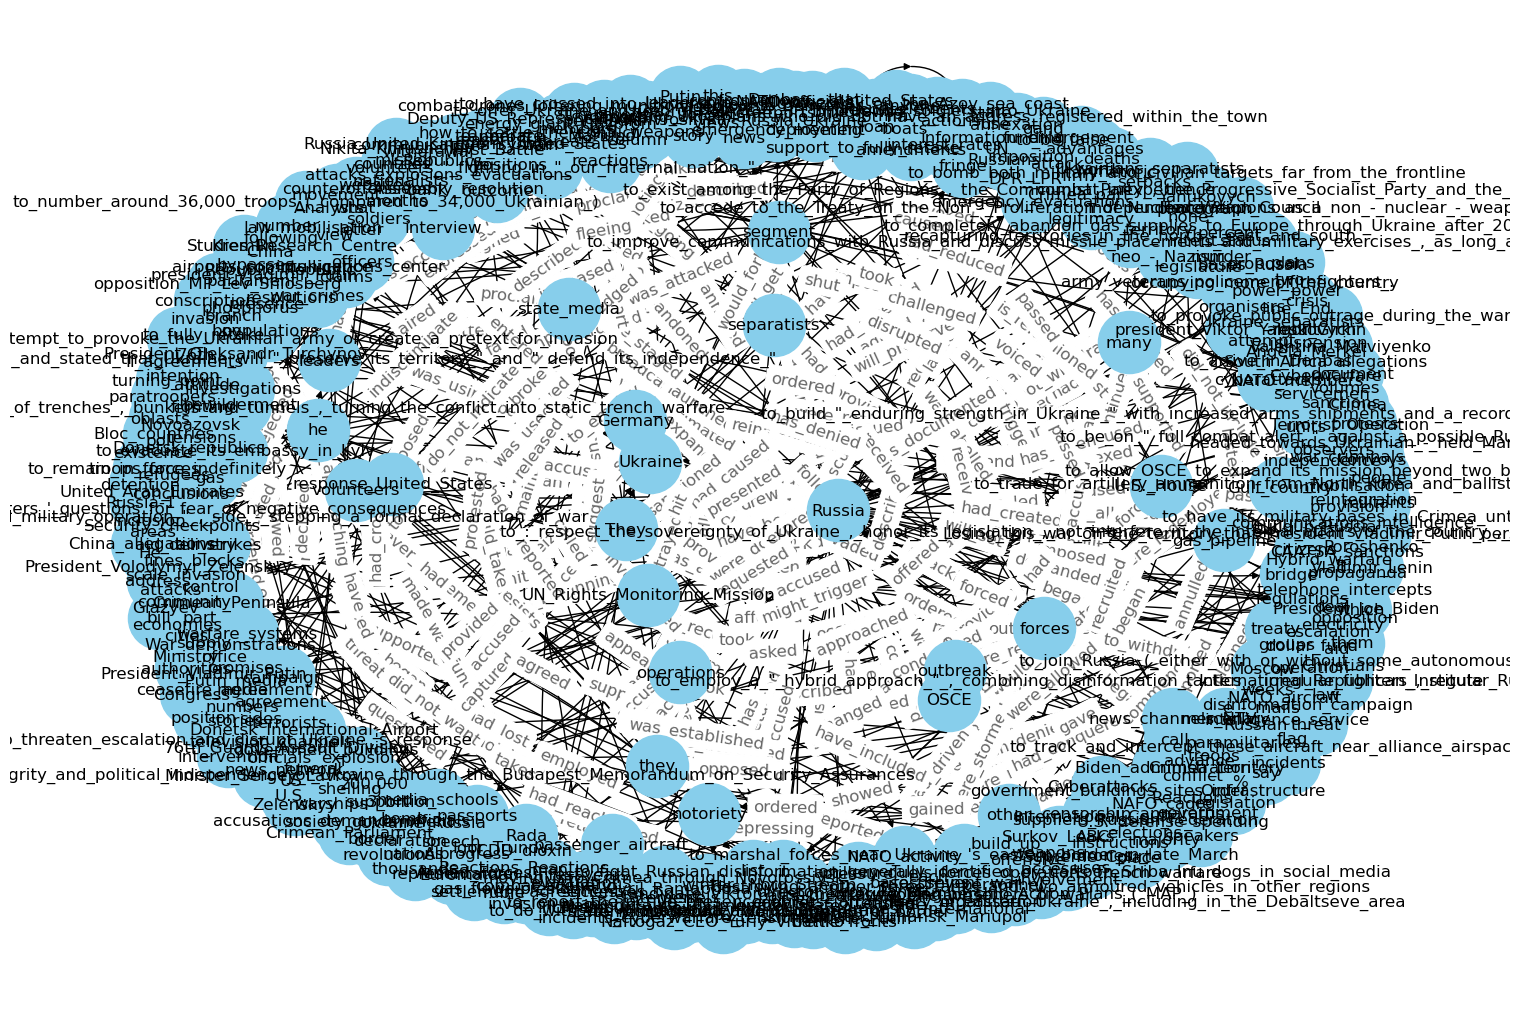

In [93]:
# Crear grafo entero
G = nx.from_pandas_edgelist(dtf, source="entity", target="object",
                            edge_attr="relation",
                            create_using=nx.DiGraph())

# Plot/Graficar
plt.figure(figsize=(15,10))

pos = nx.spring_layout(G, k=1)
node_color = "skyblue"
edge_color = "black"

nx.draw(G, pos=pos, with_labels=True, node_color=node_color,
        edge_color=edge_color, cmap=plt.cm.Dark2,
        node_size=2000, connectionstyle="arc3,rad=0.1")

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5,
                             edge_labels=nx.get_edge_attributes(G,'relation'),
                             font_size=12, font_color='black', alpha=0.6)
plt.show()

El Grafo de Conocimiento (Knowledge Graph) hace posible ver cómo todo está relacionado si miramos la imagen a escala grande. Pero así es bastante inservible. Así que es mejor si aplicamos algunos filtros en relación a la información que estamos buscando. Para este ejemplo, podríamos coger solo el nodo involucrado en la entidad más frecuente (básicamente el nodo más conectado):

In [94]:
dtf["entity"].value_counts().head()

entity
Russia     48
they       13
he         11
Ukraine    11
forces     11
Name: count, dtype: int64

In [95]:
dtf

,id,text,entity,relation,object
0,1,"Following Ukraine's Revolution of Dignity, Rus...",Russia,annexed,Crimea
1,1,"Following Ukraine's Revolution of Dignity, Rus...",Russia,supported,separatists
2,2,The first eight years of conflict also include...,years,included,incidents_cyberwarfare_tensions
3,3,"In February 2022, Russia launched a full-scale...",Russia,launched,scale_invasion
4,3,"In February 2022, Russia launched a full-scale...",Russia,began,occupying_more_of_the_country
...,...,...,...,...,...
407,390,"In March 2023, Western nations had pressed the...",nations,had_pressed,United_Arab_Emirates
408,390,"In March 2023, Western nations had pressed the...",which,had,uses
409,390,"In March 2023, Western nations had pressed the...",Gulf_country,exported,drones
410,391,"In May 2023, the U.S. accused South Africa of ...",U.S.,accused,South_Africa_allegations


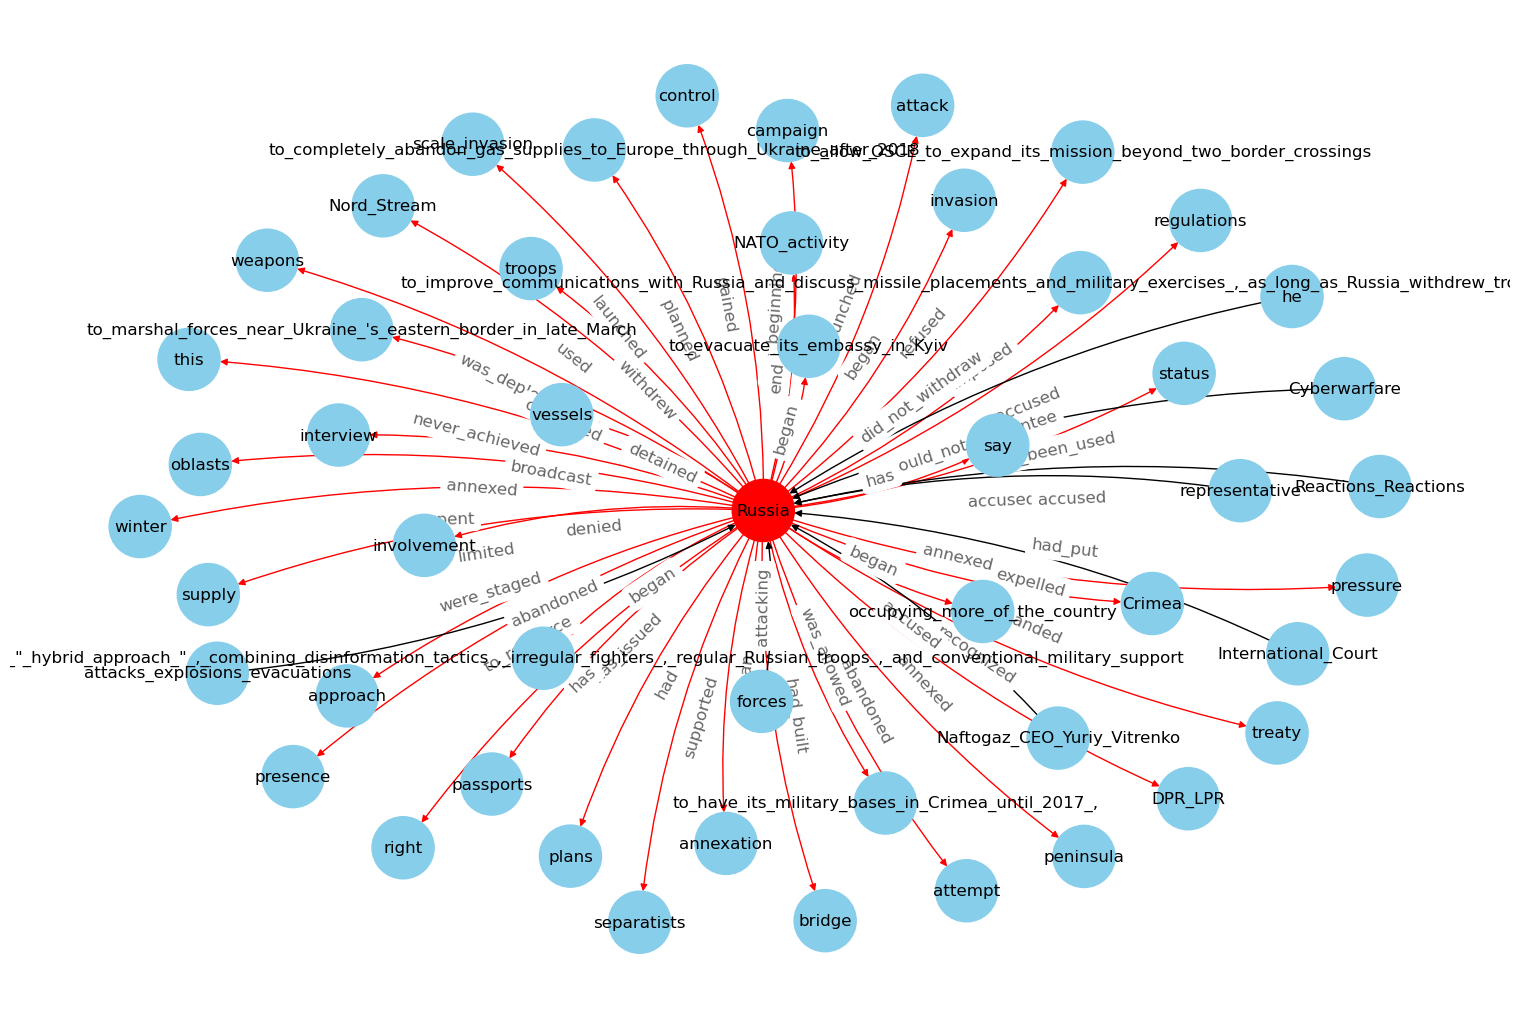

In [96]:
# Filtro
f = "Russia"
tmp = dtf[(dtf["entity"]==f) | (dtf["object"]==f)]

# Cremaos un grafo pequeño
G = nx.from_pandas_edgelist(tmp, source="entity", target="object", 
                            edge_attr="relation", 
                            create_using=nx.DiGraph())

# plot
plt.figure(figsize=(15,10))

pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
node_color = ["red" if node==f else "skyblue" for node in G.nodes]
edge_color = ["red" if edge[0]==f else "black" for edge in G.edges]

nx.draw(G, pos=pos, with_labels=True, node_color=node_color, 
        edge_color=edge_color, cmap=plt.cm.Dark2, 
        node_size=2000, node_shape="o", connectionstyle='arc3,rad=0.1')

nx.draw_networkx_edge_labels(G, pos=pos, label_pos=0.5, 
                        edge_labels=nx.get_edge_attributes(G,'relation'),
                        font_size=12, font_color='black', alpha=0.6)
plt.show()

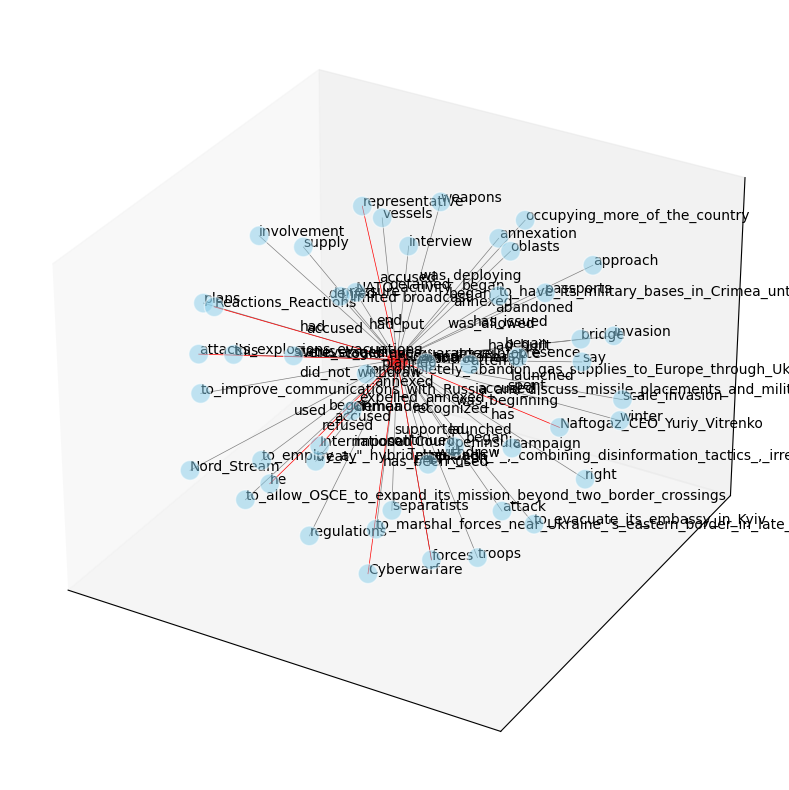

In [97]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="3d")
pos = nx.spring_layout(G, k=2.5, dim=3)

nodes = np.array([pos[v] for v in sorted(G) if v!=f])
center_node = np.array([pos[v] for v in sorted(G) if v==f])

edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v!=f])
center_edges = np.array([(pos[u],pos[v]) for u,v in G.edges() if v==f])

ax.scatter(*nodes.T, s=200, ec="w", c="skyblue", alpha=0.5)
ax.scatter(*center_node.T, s=200, c="red", alpha=0.5)

for link in edges:
    ax.plot(*link.T, color="grey", lw=0.5)
for link in center_edges:
    ax.plot(*link.T, color="red", lw=0.5)
    
for v in sorted(G):
    ax.text(*pos[v].T, s=v)
for u,v in G.edges():
    attr = nx.get_edge_attributes(G, "relation")[(u,v)]
    ax.text(*((pos[u]+pos[v])/2).T, s=attr)

ax.set(xlabel=None, ylabel=None, zlabel=None, 
       xticklabels=[], yticklabels=[], zticklabels=[])
ax.grid(False)
for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
    dim.set_ticks([])
plt.show()

Es importante decir que aunque un grafo pueda ser útil y agradable de contemplar, una de las partes más importantes del Grafo de Conocimiento en el "cononimiento" (procesamineto de texto), así después los datos pueden ser visualizados en un dataframe, un grafo, o una gráfica distinta. Por ejemplo, podría utilizar las fechas reconocidas con NER, Named Entity Recognition (Reconocimiento de Entidades Nombradas) para construir un gráfico de línea de timepo. 

---

### Gráfico de Linea de Tiempo

Antes que nada, debemos transformar las cadenas de texto o strings como "date" (fecha) a un formato "datetime". La librería `DateParser` analiza sintáticamente fechas en practicamente cualquier tipo de formato string comunmente encontrada en las páginas webs.

In [98]:
def utils_parsetime(txt):
    x = re.match(r'.=([1-3][0-9]{3})', txt)
    if x is not None:
        try:
            dt = dateparser.parse(txt)
        except:
            dt = np.nan
    else:
        dt = np.nan
    return dt

In [99]:
print(dtf_att.columns)

Index(['id', 'text', 'DATE'], dtype='object')


Apliquémoslo a los atributos del dataframe:

In [100]:
dtf_att["dt"] = dtf_att["DATE"].apply(lambda x: utils_parsetime(x))

# Ejemplo
dtf_att[dtf_att["id"]==i]

,id,text,DATE,dt
3,3,"In February 2022, Russia launched a full-scale...",February 2022,NaN


In [101]:
def utils_parsetime(txt):
    x = re.search(r'([1-3][0-9]{3})', txt)
    if x is not None:
        try:
            dt = dateparser.parse(x.group())
        except Exception as e:
            print(f"Error parsing date: {e}")
            dt = np.nan
    else:
        dt = np.nan
    return dt

# Aplica la función
dtf_att["dt"] = dtf_att["DATE"].apply(lambda x: utils_parsetime(x))

# Ejemplo
dtf_att[dtf_att["id"]==i]

,id,text,DATE,dt
3,3,"In February 2022, Russia launched a full-scale...",February 2022,2022-11-30


Ahora, deberíamos juntarlo al dataframe principal de entidades-relaciones:

In [102]:
tmp = dtf.copy()
tmp["y"] = tmp["entity"]+" "+tmp["relation"]+" "+tmp["object"]

dtf_att = dtf_att.merge(tmp[["id","y"]], how="left", on="id")
dtf_att = dtf_att[~dtf_att["y"].isna()].sort_values("dt", 
                 ascending=True).drop_duplicates("y", keep='first')
dtf_att.head()

,id,text,DATE,dt,y
201,250,The war caused the largest refugee and humanit...,1990s,1990-11-30,UN described it
200,250,The war caused the largest refugee and humanit...,1990s,1990-11-30,war caused crisis
17,27,After the dissolution of the Soviet Union (USS...,1991,1991-11-30,Ukraine_Russia maintained ties
21,32,In the years after the dissolution of the USSR...,1993,1993-11-30,Bloc_countries joined NATO
18,28,"In 1994, Ukraine agreed to accede to the Treat...",1994,1994-11-30,Ukraine agreed to_accede_to_the_Treaty_on_the_...


In [103]:
dtf_att.shape

(213, 5)

Finalmente, podemos graficar la linea de tiempo. Como ya sabemos, graficar la linea de tiempo entera no sera útil

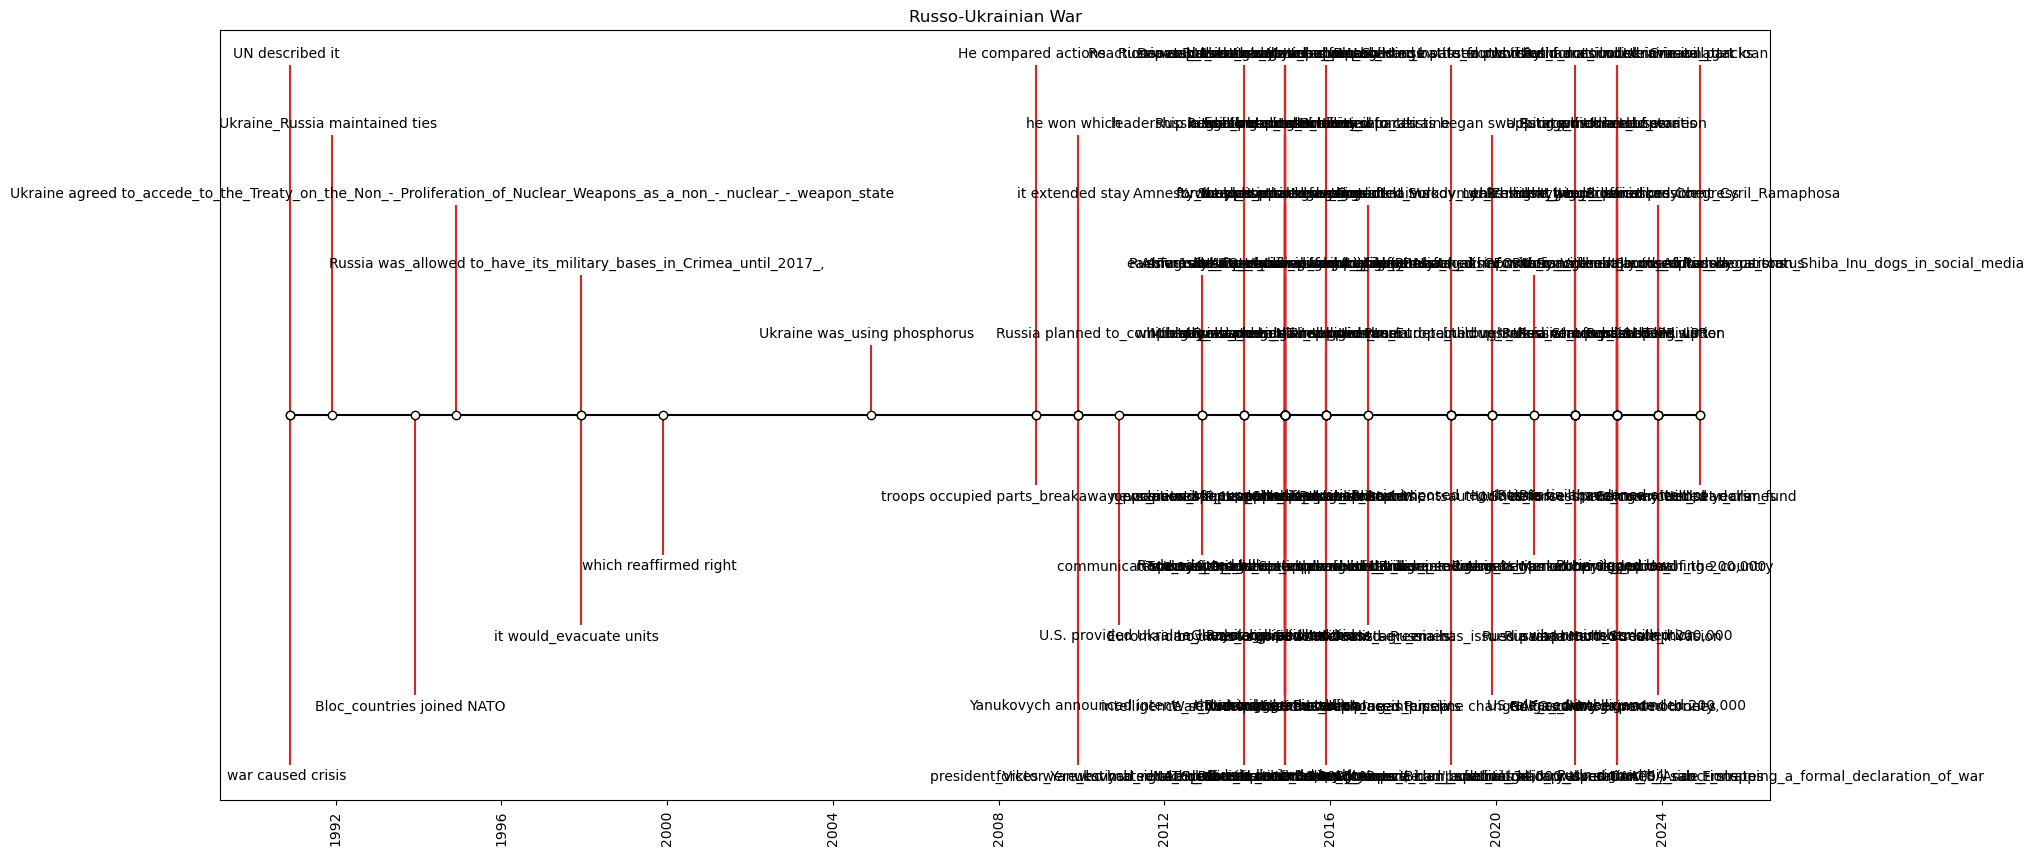

In [104]:
dates = dtf_att["dt"].values
names = dtf_att["y"].values
l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

fig, ax = plt.subplots(figsize=(20,10))
ax.set(title=topic, yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3), 
                textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90) 
plt.show()

Así que es preferible filtrar un periodo de tiempo específico:

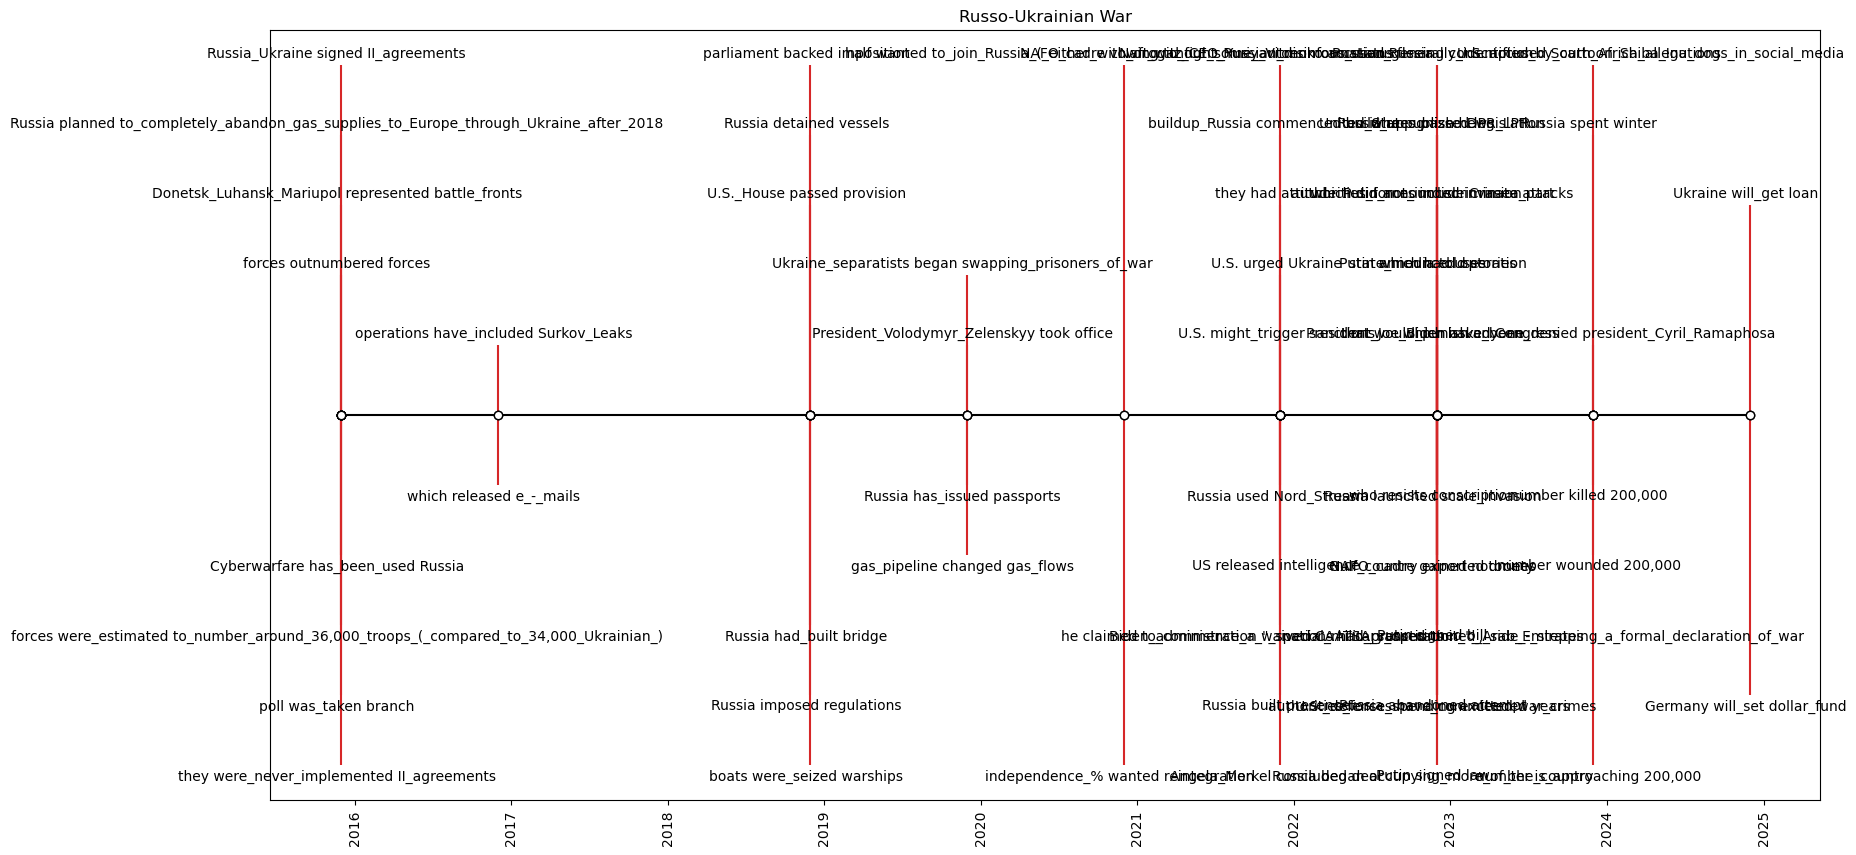

In [105]:
yyyy = "2015"
dates = dtf_att[dtf_att["dt"]>yyyy]["dt"].values
names = dtf_att[dtf_att["dt"]>yyyy]["y"].values
l = [10,-10, 8,-8, 6,-6, 4,-4, 2,-2]
levels = np.tile(l, int(np.ceil(len(dates)/len(l))))[:len(dates)]

fig, ax = plt.subplots(figsize=(20,10))
ax.set(title=topic, yticks=[], yticklabels=[])

ax.vlines(dates, ymin=0, ymax=levels, color="tab:red")
ax.plot(dates, np.zeros_like(dates), "-o", color="k", markerfacecolor="w")

for d,l,r in zip(dates,levels,names):
    ax.annotate(r, xy=(d,l), xytext=(-3, np.sign(l)*3), 
                textcoords="offset points",
                horizontalalignment="center",
                verticalalignment="bottom" if l>0 else "top")

plt.xticks(rotation=90) 
plt.show()

Como podemos observar, una vez que el conocimiento ha sido extraído, en la manera que nos plazca.

---

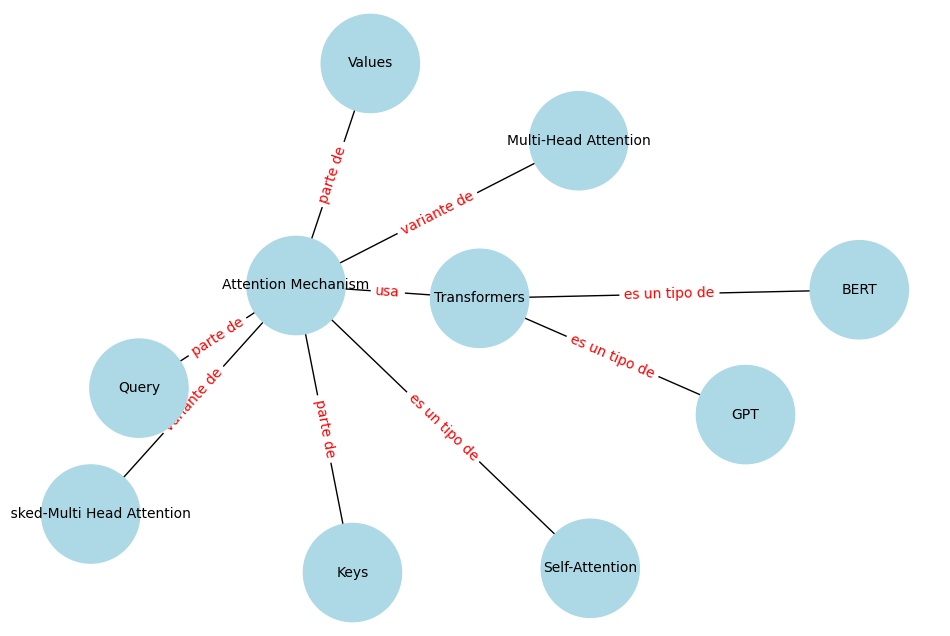

In [107]:
# Creando un grafo de conocimiento basado en el texto sobre mecanismos de atención en IA

# Crear un nuevo grafo dirigido
G_attention = nx.DiGraph()

# Añadir nodos (Entidades clave)
entities = [
    "Attention Mechanism", "Self-Attention", "Query", "Keys", "Values",
    "Multi-Head Attention", "Masked-Multi Head Attention", "Transformers", "BERT", "GPT"
]
for entity in entities:
    G_attention.add_node(entity, node_color='lightblue')

# Añadir aristas (Relaciones)
relations = [
    ("Self-Attention", "Attention Mechanism", 'es un tipo de'),
    ("Query", "Attention Mechanism", 'parte de'),
    ("Keys", "Attention Mechanism", 'parte de'),
    ("Values", "Attention Mechanism", 'parte de'),
    ("Multi-Head Attention", "Attention Mechanism", 'variante de'),
    ("Masked-Multi Head Attention", "Attention Mechanism", 'variante de'),
    ("Transformers", "Attention Mechanism", 'usa'),
    ("BERT", "Transformers", 'es un tipo de'),
    ("GPT", "Transformers", 'es un tipo de')
]
for src, dst, rel in relations:
    G_attention.add_edge(src, dst, relationship=rel)

# Dibujar el grafo
pos_attention = nx.spring_layout(G_attention)  # Posicionamiento de los nodos
plt.figure(figsize=(12, 8))

# Dibujar nodos
nx.draw_networkx_nodes(G_attention, pos_attention, node_size=5000, node_color=[G_attention.nodes[n]['node_color'] for n in G_attention.nodes])

# Dibujar aristas
nx.draw_networkx_edges(G_attention, pos_attention, arrowstyle='->', arrowsize=20)

# Etiquetas para los nodos
nx.draw_networkx_labels(G_attention, pos_attention, font_size=10, font_family='sans-serif')

# Etiquetas para las aristas
edge_labels_attention = nx.get_edge_attributes(G_attention, 'relationship')
nx.draw_networkx_edge_labels(G_attention, pos_attention, edge_labels=edge_labels_attention, font_color='red')

plt.axis('off')
plt.show()


NetworkXError: Node 'Mecanismo de Atención' has no position.

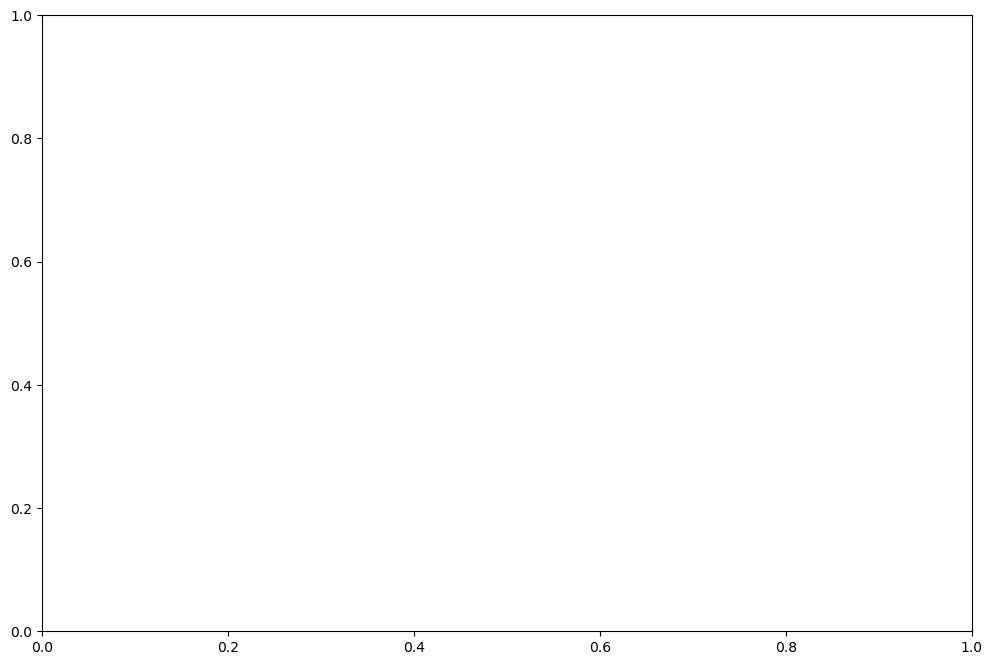

In [108]:
# Traduciendo los nombres de los nodos al español para el grafo

# Nombres de nodos en español
translations = {
    "Attention Mechanism": "Mecanismo de Atención",
    "Self-Attention": "Auto-Atención",
    "Query": "Consulta",
    "Keys": "Llaves",
    "Values": "Valores",
    "Multi-Head Attention": "Atención Multi-Cabeza",
    "Masked-Multi Head Attention": "Atención Multi-Cabeza Enmascarada",
    "Transformers": "Transformadores",
    "BERT": "BERT",
    "GPT": "GPT"
}

# Actualizar los nombres de los nodos en el grafo
G_attention_translated = nx.relabel_nodes(G_attention, translations)

# Dibujar el grafo con nombres en español
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_attention_translated, pos_attention, node_size=5000, node_color=[G_attention_translated.nodes[n]['node_color'] for n in G_attention_translated.nodes])
nx.draw_networkx_edges(G_attention_translated, pos_attention, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G_attention_translated, pos_attention, font_size=10, font_family='sans-serif')
nx.draw_networkx_edge_labels(G_attention_translated, pos_attention, edge_labels=edge_labels_attention, font_color='red')
plt.axis('off')
plt.show()


KeyError: 'Self-Attention'

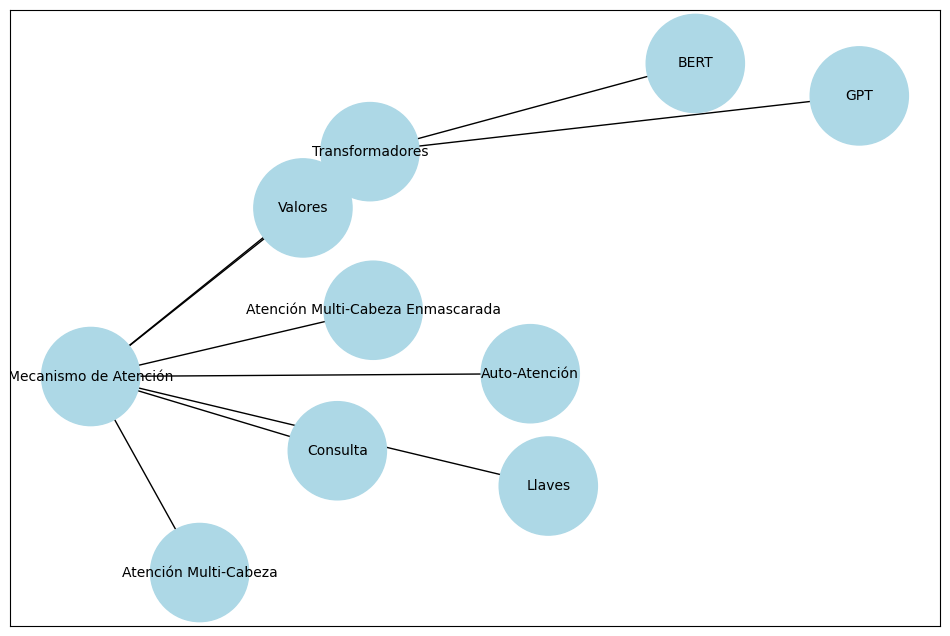

In [109]:
# Recalculando las posiciones de los nodos para el grafo con nombres en español
pos_attention_translated = nx.spring_layout(G_attention_translated)

# Dibujar el grafo con nombres en español
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_attention_translated, pos_attention_translated, node_size=5000, node_color=[G_attention_translated.nodes[n]['node_color'] for n in G_attention_translated.nodes])
nx.draw_networkx_edges(G_attention_translated, pos_attention_translated, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G_attention_translated, pos_attention_translated, font_size=10, font_family='sans-serif')
nx.draw_networkx_edge_labels(G_attention_translated, pos_attention_translated, edge_labels=edge_labels_attention, font_color='red')
plt.axis('off')
plt.show()


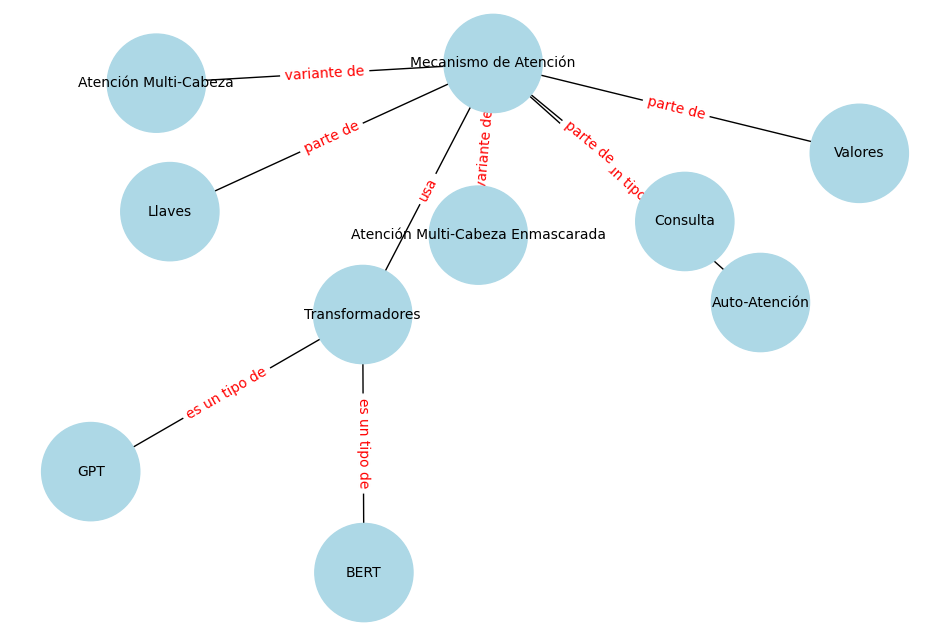

In [ ]:
# Traduciendo las etiquetas de las aristas al español
translated_edge_labels = {
    (translations[src], translations[dst]): rel for (src, dst), rel in edge_labels_attention.items()
}

# Dibujar el grafo con nombres y etiquetas de aristas en español
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_attention_translated, pos_attention_translated, node_size=5000, node_color=[G_attention_translated.nodes[n]['node_color'] for n in G_attention_translated.nodes])
nx.draw_networkx_edges(G_attention_translated, pos_attention_translated, arrowstyle='->', arrowsize=20)
nx.draw_networkx_labels(G_attention_translated, pos_attention_translated, font_size=10, font_family='sans-serif')
nx.draw_networkx_edge_labels(G_attention_translated, pos_attention_translated, edge_labels=translated_edge_labels, font_color='red')
plt.axis('off')
plt.show()


Esto es mejor que lo anterior.

Provemos ahora con una grafica 3D.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection="3D")
pos = nx.spring_layout(G, k=2.5, dim=3)

nodes = np.array([pos[v] for v in sorted(G) if v != f])
center_node = np.array([pos[v] for v in sorted(G) if v == f])

edges = np.array([(pos[u], pos[v]) for u, v in G.edges() if v != f])
center_edges = np.array([(pos[u], pos[v]) for u, v in G.edges() if v == f])

ax.scatter(*nodes.T, s=200, ec="w", c="skyblue", alpha=0.5)
ax.scatter(*center_node.T, s=200, c="red", alpha=0.5)

for link in edges:
    ax.plot(*link.T, color="grey", lw=0.5)
for link in center_edges:
    ax.plot(*link.T, color="red", lw=0.5)

for v in sorted(G):
    ax.text(*pos[v].T, s=v)
for u, v in G.edges():
    attr = nx.get_edge_attributes(G, "relation")[(u, v)]
    ax.text(*((pos[])))